# Mercari Price Suggestion Challenge - HW

**Задача:** Предсказание цены товара на основе его описания, категории, бренда и состояния.

**Метрика:** RMSLE (Root Mean Squared Logarithmic Error)

## 1. Импорт библиотек и загрузка данных


In [1]:
# Установка
!pip install lightautoml py7zr -q


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 11.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.5/99.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 47.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Распаковка архивов
from pathlib import Path
import zipfile
import py7zr

data_dir = Path("/kaggle/input/mercari-price-suggestion-challenge")
out_dir = Path("/kaggle/working")

if data_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # 7z архивы
    seven_z = [
        ("sample_submission.csv.7z", "sample_submission.csv"),
        ("test.tsv.7z", "test.tsv"),
        ("train.tsv.7z", "train.tsv"),
    ]
    
    # zip архивы
    zip_files = [
        ("sample_submission_stg2.csv.zip", "sample_submission_stg2.csv"),
        ("test_stg2.tsv.zip", "test_stg2.tsv"),
    ]
    
    for arc_name, target in seven_z:
        p = out_dir / target
        if not p.exists():
            with py7zr.SevenZipFile(data_dir / arc_name, "r") as f:
                f.extractall(out_dir)
    
    for arc_name, target in zip_files:
        p = out_dir / target
        if not p.exists():
            with zipfile.ZipFile(data_dir / arc_name, "r") as f:
                f.extractall(out_dir)
    
    print("Архивы распакованы")

Архивы распакованы


In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import gc
import logging
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from scipy import stats
from scipy.sparse import hstack, csr_matrix

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Библиотеки успешно загружены")

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
Библиотеки успешно загружены


In [4]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Вычисление Root Mean Squared Logarithmic Error.
    
    Parameters:
    -----------
    y_true : np.ndarray
        Истинные значения
    y_pred : np.ndarray
        Предсказанные значения
        
    Returns:
    --------
    float
        Значение RMSLE
    """
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


In [5]:
# Загрузка данных
logger.info("Загрузка данных...")

train = pd.read_csv('train.tsv', sep='\t', nrows=500000)
test = pd.read_csv('test.tsv', sep='\t')

logger.info(f"Train shape: {train.shape}")
logger.info(f"Test shape: {test.shape}")

print("\nПервые строки train данных:")
train.head()


2025-12-09 12:47:27,902 - INFO - Загрузка данных...
2025-12-09 12:47:34,148 - INFO - Train shape: (500000, 8)
2025-12-09 12:47:34,149 - INFO - Test shape: (693359, 7)



Первые строки train данных:


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
# Информация о данных
print("Информация о train датасете:")
print(train.info())
print("\n" + "="*50)
print("\nСтатистика по числовым признакам:")
train.describe()


Информация о train датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           500000 non-null  int64  
 1   name               500000 non-null  object 
 2   item_condition_id  500000 non-null  int64  
 3   category_name      497857 non-null  object 
 4   brand_name         286632 non-null  object 
 5   price              500000 non-null  float64
 6   shipping           500000 non-null  int64  
 7   item_description   499999 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 30.5+ MB
None


Статистика по числовым признакам:


,train_id,item_condition_id,price,shipping
count,500000.000000,500000.000000,500000.000000,500000.000000
mean,249999.500000,1.907302,26.704171,0.446304
std,144337.711634,0.902567,38.583005,0.497109
min,0.000000,1.000000,0.000000,0.000000
25%,124999.750000,1.000000,10.000000,0.000000
50%,249999.500000,2.000000,17.000000,0.000000
75%,374999.250000,3.000000,29.000000,1.000000
max,499999.000000,5.000000,2000.000000,1.000000


---
## 2. Анализ целевой переменной (price)

Целевая переменная - цена товара в USD.


In [7]:
# Численный анализ целевой переменной
print("=" * 60)
print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (PRICE)")
print("=" * 60)

print(f"\nБазовая статистика:")
print(f"  Количество записей: {len(train):,}")
print(f"  Среднее значение: ${train['price'].mean():.2f}")
print(f"  Медиана: ${train['price'].median():.2f}")
print(f"  Стандартное отклонение: ${train['price'].std():.2f}")
print(f"  Минимум: ${train['price'].min():.2f}")
print(f"  Максимум: ${train['price'].max():.2f}")

# Квантили
print(f"\nКвантили:")
for q in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]:
    print(f"  {int(q*100)}%: ${train['price'].quantile(q):.2f}")

# Асимметрия и эксцесс
print(f"\nФорма распределения:")
print(f"  Асимметрия (skewness): {train['price'].skew():.2f}")
print(f"  Эксцесс (kurtosis): {train['price'].kurtosis():.2f}")


АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (PRICE)

Базовая статистика:
  Количество записей: 500,000
  Среднее значение: $26.70
  Медиана: $17.00
  Стандартное отклонение: $38.58
  Минимум: $0.00
  Максимум: $2000.00

Квантили:
  1%: $3.00
  5%: $6.00
  25%: $10.00
  50%: $17.00
  75%: $29.00
  95%: $75.00
  99%: $170.00

Форма распределения:
  Асимметрия (skewness): 11.64
  Эксцесс (kurtosis): 292.52


In [8]:
# Поиск аномальных значений
print("\n" + "=" * 60)
print("ПОИСК АНОМАЛЬНЫХ ЗНАЧЕНИЙ")
print("=" * 60)

zero_prices = train[train['price'] == 0]
print(f"\nТовары с нулевой ценой: {len(zero_prices):,} ({len(zero_prices)/len(train)*100:.2f}%)")

low_prices = train[train['price'] < 3]
print(f"Товары с ценой < $3: {len(low_prices):,} ({len(low_prices)/len(train)*100:.2f}%)")

high_prices = train[train['price'] > 500]
print(f"Товары с ценой > $500: {len(high_prices):,} ({len(high_prices)/len(train)*100:.2f}%)")

# IQR метод для выбросов
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = train[(train['price'] < lower_bound) | (train['price'] > upper_bound)]
print(f"\nВыбросы по IQR методу (границы: ${lower_bound:.2f} - ${upper_bound:.2f}):")
print(f"  Количество: {len(outliers_iqr):,} ({len(outliers_iqr)/len(train)*100:.2f}%)")



ПОИСК АНОМАЛЬНЫХ ЗНАЧЕНИЙ

Товары с нулевой ценой: 260 (0.05%)
Товары с ценой < $3: 260 (0.05%)
Товары с ценой > $500: 373 (0.07%)

Выбросы по IQR методу (границы: $-18.50 - $57.50):
  Количество: 40,149 (8.03%)


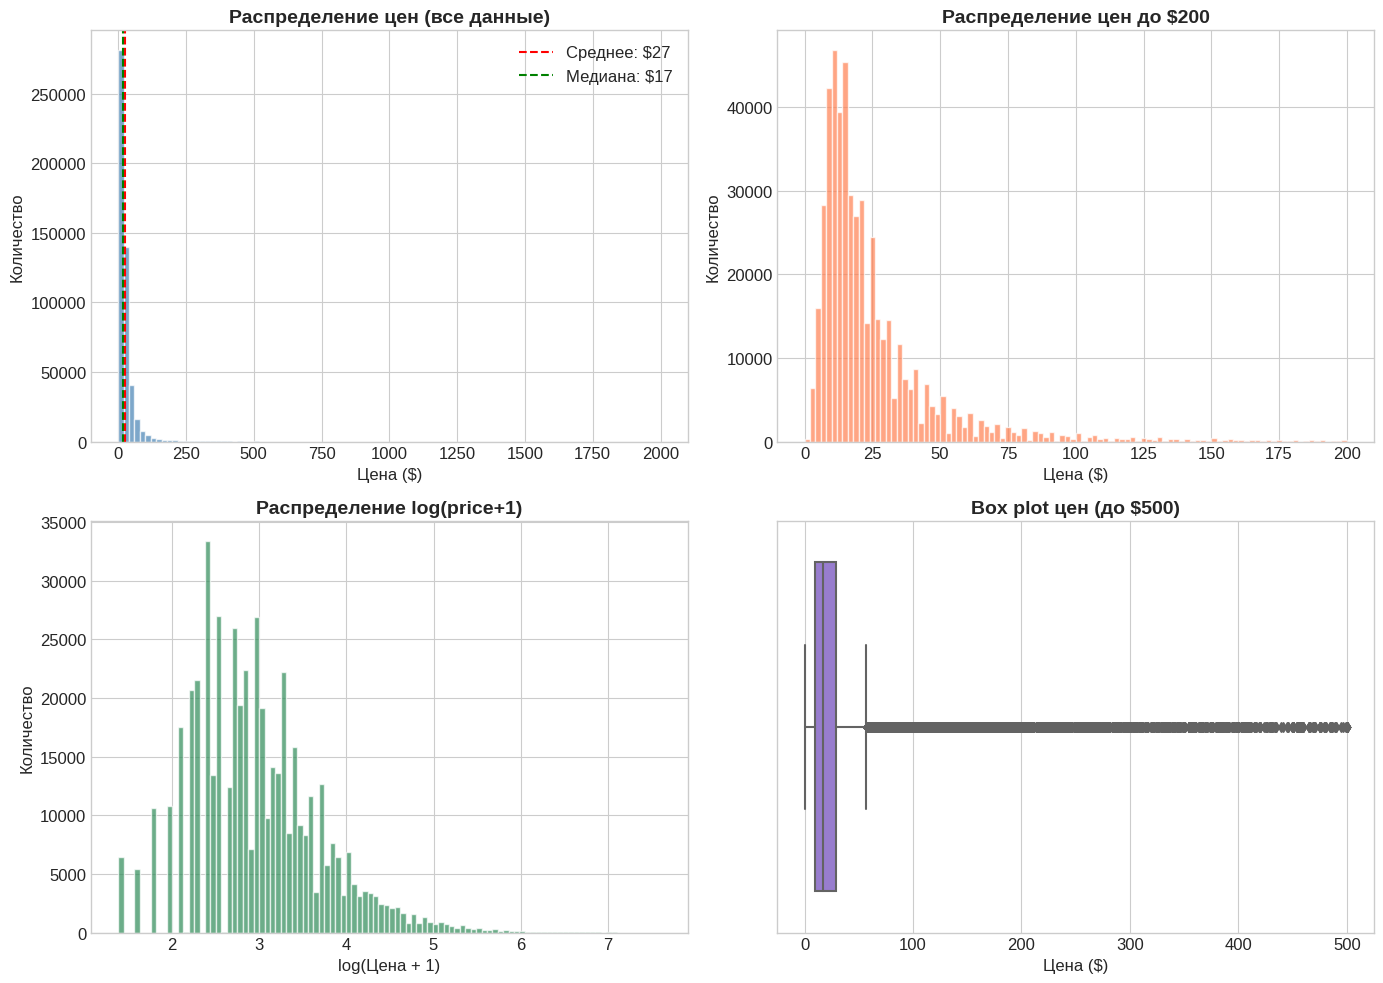

In [9]:
# Визуализация целевой переменной
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
train['price'].hist(bins=100, ax=ax1, color='steelblue', edgecolor='white', alpha=0.7)
ax1.set_title('Распределение цен (все данные)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Цена ($)')
ax1.set_ylabel('Количество')
ax1.axvline(train['price'].mean(), color='red', linestyle='--', label=f'Среднее: ${train["price"].mean():.0f}')
ax1.axvline(train['price'].median(), color='green', linestyle='--', label=f'Медиана: ${train["price"].median():.0f}')
ax1.legend()

ax2 = axes[0, 1]
train[train['price'] <= 200]['price'].hist(bins=100, ax=ax2, color='coral', edgecolor='white', alpha=0.7)
ax2.set_title('Распределение цен до $200', fontsize=14, fontweight='bold')
ax2.set_xlabel('Цена ($)')
ax2.set_ylabel('Количество')

ax3 = axes[1, 0]
train_nonzero = train[train['price'] > 0]
np.log1p(train_nonzero['price']).hist(bins=100, ax=ax3, color='seagreen', edgecolor='white', alpha=0.7)
ax3.set_title('Распределение log(price+1)', fontsize=14, fontweight='bold')
ax3.set_xlabel('log(Цена + 1)')
ax3.set_ylabel('Количество')

ax4 = axes[1, 1]
sns.boxplot(x=train[train['price'] <= 500]['price'], ax=ax4, color='mediumpurple')
ax4.set_title('Box plot цен (до $500)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Цена ($)')

plt.tight_layout()
plt.show()


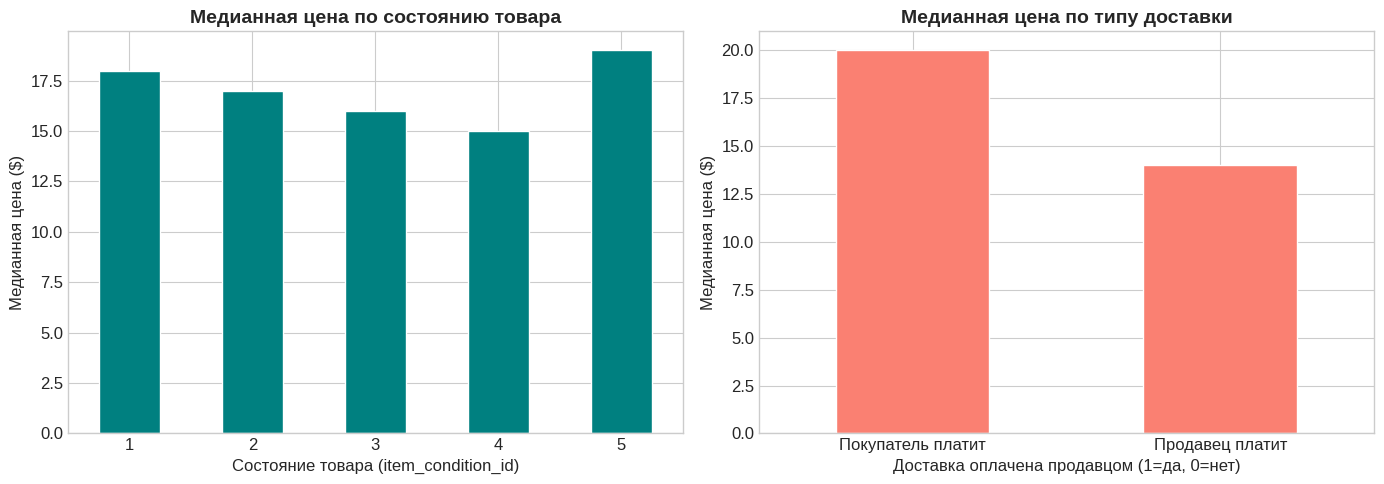

In [10]:
# Анализ распределения цен по категориям
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
train.groupby('item_condition_id')['price'].median().plot(kind='bar', ax=ax1, color='teal', edgecolor='white')
ax1.set_title('Медианная цена по состоянию товара', fontsize=14, fontweight='bold')
ax1.set_xlabel('Состояние товара (item_condition_id)')
ax1.set_ylabel('Медианная цена ($)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2 = axes[1]
train.groupby('shipping')['price'].median().plot(kind='bar', ax=ax2, color='salmon', edgecolor='white')
ax2.set_title('Медианная цена по типу доставки', fontsize=14, fontweight='bold')
ax2.set_xlabel('Доставка оплачена продавцом (1=да, 0=нет)')
ax2.set_ylabel('Медианная цена ($)')
ax2.set_xticklabels(['Покупатель платит', 'Продавец платит'], rotation=0)

plt.tight_layout()
plt.show()


### Выводы по целевой переменной:

1. **Сильная правая асимметрия** - большинство товаров стоят недорого, но есть редкие дорогие товары
2. **Необходимо логарифмирование** - распределение log(price) близко к нормальному
3. **Есть нулевые цены** - это аномалии, которые нужно удалить
4. **Состояние товара влияет на цену** - новые товары (condition_id=1) дороже
5. **Бесплатная доставка коррелирует с более низкой ценой**

---
## 3. Анализ признаков (EDA)


In [11]:
# Типизация признаков
print("=" * 60)
print("ТИПИЗАЦИЯ ПРИЗНАКОВ")
print("=" * 60)

feature_types = {
    'train_id': 'ID (не используется)',
    'name': 'Текстовый (название товара)',
    'item_condition_id': 'Категориальный (порядковый, 1-5)',
    'category_name': 'Категориальный (иерархический)',
    'brand_name': 'Категориальный (высокая кардинальность)',
    'price': 'Числовой (целевая переменная)',
    'shipping': 'Бинарный (0/1)',
    'item_description': 'Текстовый (описание товара)'
}

for col, dtype in feature_types.items():
    print(f"  {col}: {dtype}")


ТИПИЗАЦИЯ ПРИЗНАКОВ
  train_id: ID (не используется)
  name: Текстовый (название товара)
  item_condition_id: Категориальный (порядковый, 1-5)
  category_name: Категориальный (иерархический)
  brand_name: Категориальный (высокая кардинальность)
  price: Числовой (целевая переменная)
  shipping: Бинарный (0/1)
  item_description: Текстовый (описание товара)



АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Train данные:
                   Пропусков  Процент (%)
train_id                   0         0.00
name                       0         0.00
item_condition_id          0         0.00
category_name           2143         0.43
brand_name            213368        42.67
price                      0         0.00
shipping                   0         0.00
item_description           1         0.00


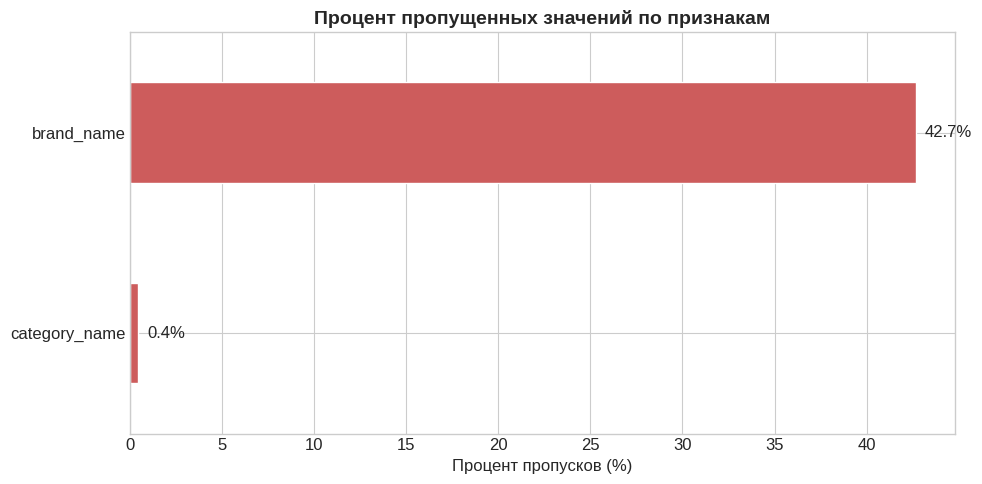

In [12]:
# Анализ пропущенных значений
print("\n" + "=" * 60)
print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("=" * 60)

missing_train = train.isnull().sum()
missing_pct = (missing_train / len(train) * 100).round(2)

missing_df = pd.DataFrame({
    'Пропусков': missing_train,
    'Процент (%)': missing_pct
})

print("\nTrain данные:")
print(missing_df)

# Визуализация пропусков
fig, ax = plt.subplots(figsize=(10, 5))
missing_pct_plot = missing_pct[missing_pct > 0].sort_values(ascending=True)
missing_pct_plot.plot(kind='barh', ax=ax, color='indianred', edgecolor='white')
ax.set_title('Процент пропущенных значений по признакам', fontsize=14, fontweight='bold')
ax.set_xlabel('Процент пропусков (%)')
for i, v in enumerate(missing_pct_plot):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center')
plt.tight_layout()
plt.show()



АНАЛИЗ ТЕКСТОВЫХ ПРИЗНАКОВ

Название товара (name):
  Средняя длина: 25.8 символов

Описание товара (item_description):
  Средняя длина: 145.6 символов


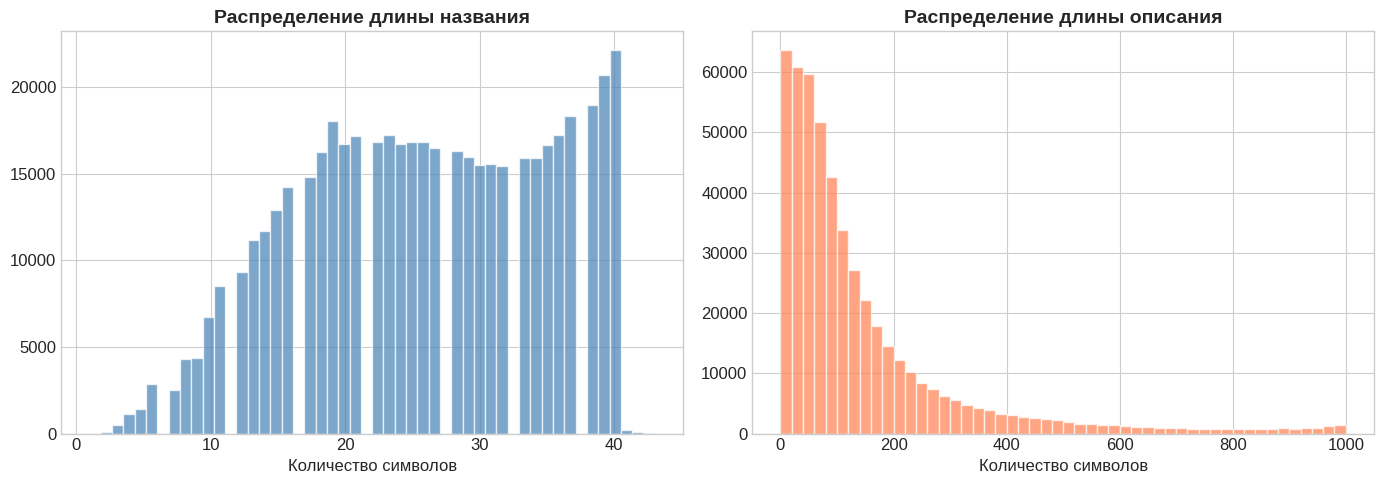

In [13]:
# Анализ текстовых признаков
print("\n" + "=" * 60)
print("АНАЛИЗ ТЕКСТОВЫХ ПРИЗНАКОВ")
print("=" * 60)

train['name_len'] = train['name'].fillna('').apply(len)
train['desc_len'] = train['item_description'].fillna('').apply(len)

print("\nНазвание товара (name):")
print(f"  Средняя длина: {train['name_len'].mean():.1f} символов")

print("\nОписание товара (item_description):")
print(f"  Средняя длина: {train['desc_len'].mean():.1f} символов")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train['name_len'].hist(bins=50, ax=axes[0], color='steelblue', edgecolor='white', alpha=0.7)
axes[0].set_title('Распределение длины названия', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Количество символов')

train[train['desc_len'] < 1000]['desc_len'].hist(bins=50, ax=axes[1], color='coral', edgecolor='white', alpha=0.7)
axes[1].set_title('Распределение длины описания', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Количество символов')

plt.tight_layout()
plt.show()



АНАЛИЗ КАТЕГОРИЙ

Главные категории (11 шт.):
cat_main
Women                     224059
Beauty                     70228
Kids                       57696
Electronics                41376
Men                        31627
Home                       23016
Vintage & Collectibles     15756
Other                      15365
Handmade                   10310
Sports & Outdoors           8424
missing                     2143
Name: count, dtype: int64


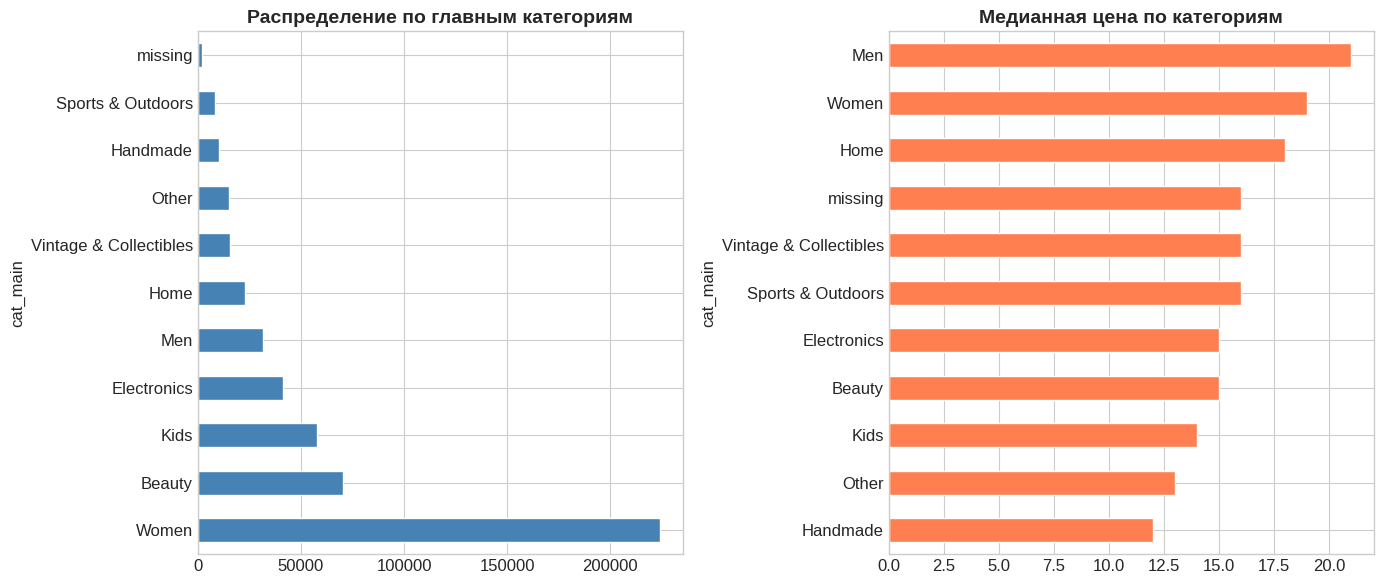

In [14]:
# Анализ категорий
print("\n" + "=" * 60)
print("АНАЛИЗ КАТЕГОРИЙ")
print("=" * 60)

def split_category(cat):
    if pd.isna(cat):
        return ['missing', 'missing', 'missing']
    parts = cat.split('/')
    while len(parts) < 3:
        parts.append('missing')
    return parts[:3]

categories_split = train['category_name'].apply(split_category)
train['cat_main'] = categories_split.apply(lambda x: x[0])

print(f"\nГлавные категории ({train['cat_main'].nunique()} шт.):")
print(train['cat_main'].value_counts())

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cat_counts = train['cat_main'].value_counts()
cat_counts.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Распределение по главным категориям', fontsize=14, fontweight='bold')

cat_median_price = train.groupby('cat_main')['price'].median().sort_values()
cat_median_price.plot(kind='barh', ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Медианная цена по категориям', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

Корреляция с целевой переменной (price):
price                1.000000
desc_len             0.047582
name_len             0.026265
item_condition_id   -0.001895
shipping            -0.096645
Name: price, dtype: float64


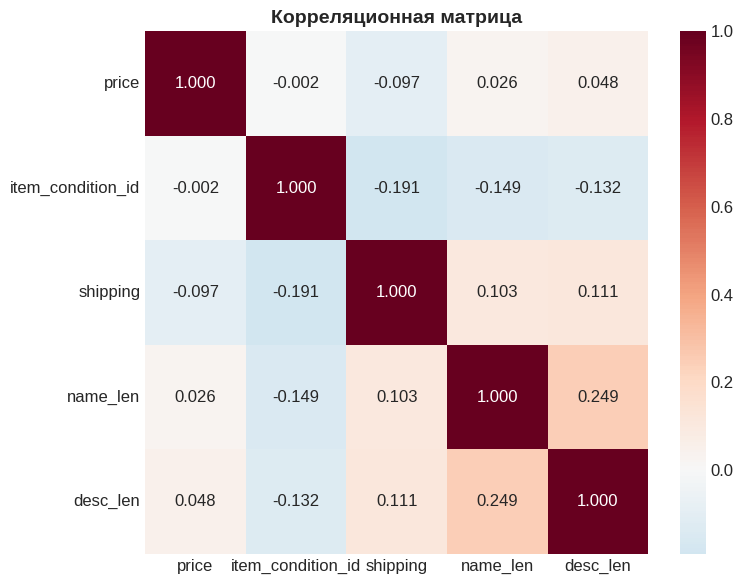

In [15]:
# Корреляционный анализ
print("\n" + "=" * 60)
print("КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")
print("=" * 60)

numeric_features = ['price', 'item_condition_id', 'shipping', 'name_len', 'desc_len']
corr_matrix = train[numeric_features].corr()

print("\nКорреляция с целевой переменной (price):")
print(corr_matrix['price'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.3f', ax=ax)
ax.set_title('Корреляционная матрица', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---
## 4. Подготовка данных


In [16]:
# Очистка и перезагрузка данных
train.drop(columns=['name_len', 'desc_len', 'cat_main'], inplace=True, errors='ignore')

train = pd.read_csv('train.tsv', sep='\t', nrows=500000)
test = pd.read_csv('test.tsv', sep='\t')

# Удаление товаров с нулевой ценой
print(f"Товаров с нулевой ценой: {(train['price'] == 0).sum()}")
train = train[train['price'] > 0].reset_index(drop=True)
print(f"Train shape после удаления: {train.shape}")


Товаров с нулевой ценой: 260
Train shape после удаления: (499740, 8)


In [17]:
# Разделение на train/validation
print("\n" + "=" * 60)
print("СТРАТЕГИЯ РАЗДЕЛЕНИЯ ДАННЫХ")
print("=" * 60)

print("""
Обоснование стратегии:
1. Используем holdout validation (80/20) для финальной оценки
2. Данные перемешиваются случайным образом
3. Нет временной компоненты - можно использовать случайное разделение
4. Для предотвращения утечки данных:
   - Все трансформации (TF-IDF, encoding) обучаются только на train
""")

X = train.drop(['price', 'train_id'], axis=1)
y = train['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(f"\nРазмеры выборок:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")



СТРАТЕГИЯ РАЗДЕЛЕНИЯ ДАННЫХ

Обоснование стратегии:
1. Используем holdout validation (80/20) для финальной оценки
2. Данные перемешиваются случайным образом
3. Нет временной компоненты - можно использовать случайное разделение
4. Для предотвращения утечки данных:
   - Все трансформации (TF-IDF, encoding) обучаются только на train


Размеры выборок:
  X_train: (399792, 6)
  X_val: (99948, 6)


---
## 5. LAMA Baseline


In [18]:
# Подготовка данных для LAMA
train_lama = pd.concat([X_train, y_train.rename('price')], axis=1).reset_index(drop=True)
val_lama = pd.concat([X_val, y_val.rename('price')], axis=1).reset_index(drop=True)

for df in [train_lama, val_lama]:
    df['name'] = df['name'].fillna('')
    df['item_description'] = df['item_description'].fillna('No description')
    df['brand_name'] = df['brand_name'].fillna('missing')
    df['category_name'] = df['category_name'].fillna('missing')

print(f"Train LAMA shape: {train_lama.shape}")


Train LAMA shape: (399792, 7)


In [19]:
# LAMA Конфигурация 1: Базовая (без текста)
print("\n" + "=" * 60)
print("LAMA BASELINE #1: Базовая конфигурация")
print("=" * 60)

train_lama_simple = train_lama[['item_condition_id', 'shipping', 'brand_name', 'category_name', 'price']].copy()
val_lama_simple = val_lama[['item_condition_id', 'shipping', 'brand_name', 'category_name', 'price']].copy()

task = Task('reg', loss='rmsle', metric='rmsle')

automl_simple = TabularAutoML(
    task=task,
    timeout=300,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': RANDOM_STATE}
)

roles_simple = {
    'target': 'price',
    'category': ['item_condition_id', 'shipping', 'brand_name', 'category_name']
}

logger.info("Обучение LAMA...")
oof_pred_simple = automl_simple.fit_predict(train_lama_simple, roles=roles_simple)

val_pred_simple = automl_simple.predict(val_lama_simple).data[:, 0]
lama_rmsle_simple = rmsle(y_val.values, np.maximum(val_pred_simple, 0))
print(f"\nLAMA Baseline #1 RMSLE: {lama_rmsle_simple:.5f}")


2025-12-09 12:47:47,917 - INFO - Обучение LAMA...



LAMA BASELINE #1: Базовая конфигурация


2025-12-09 12:48:54,984 - INFO - A new study created in memory with name: no-name-5a673f45-f43e-408e-a94f-b4cb4e739b51
2025-12-09 12:48:59,498 - INFO - Trial 0 finished with value: -0.7238401033942378 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.7238401033942378.
2025-12-09 12:49:42,600 - INFO - A new study created in memory with name: no-name-5fcab71a-1376-463b-85ef-ec665f2ca559
2025-12-09 12:49:49,829 - INFO - Trial 0 finished with value: -0.7238577728782176 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.7238577728782176.
2025-12-09 12:49:58,037 - INFO - Trial 1 finished with value: -0.7238518589694571 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_


LAMA Baseline #1 RMSLE: 0.58516


In [20]:
# LAMA Конфигурация 2: С текстом
print("\n" + "=" * 60)
print("LAMA BASELINE #2: С текстовыми признаками")
print("=" * 60)

task = Task('reg', loss='rmsle', metric='rmsle')

automl_full = TabularAutoML(
    task=task,
    timeout=600,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': RANDOM_STATE}
)

roles_full = {
    'target': 'price',
    'category': ['item_condition_id', 'shipping', 'brand_name', 'category_name'],
    'text': ['name', 'item_description']
}

logger.info("Обучение LAMA (с текстом)...")
oof_pred_full = automl_full.fit_predict(train_lama, roles=roles_full)

val_pred_full = automl_full.predict(val_lama).data[:, 0]
lama_rmsle_full = rmsle(y_val.values, np.maximum(val_pred_full, 0))
print(f"\nLAMA Baseline #2 RMSLE: {lama_rmsle_full:.5f}")

best_lama_rmsle = min(lama_rmsle_simple, lama_rmsle_full)
print(f"\nЛучший LAMA RMSLE: {best_lama_rmsle:.5f}")


2025-12-09 12:51:07,443 - INFO - Обучение LAMA (с текстом)...



LAMA BASELINE #2: С текстовыми признаками


2025-12-09 12:52:05,426 - INFO - A new study created in memory with name: no-name-3bc50c49-e2de-47d4-8d8e-2793a0980269
2025-12-09 12:52:09,923 - INFO - Trial 0 finished with value: -0.7238401033942378 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.7238401033942378.
2025-12-09 12:52:14,631 - INFO - Trial 1 finished with value: -0.7238402579675668 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: -0.7238401033942378.
2025-12-09 12:52:22,735 - INFO - Trial 2 finished with value: -0.7238364544194399 and parameters: {'feature_fraction': 0.9162213204002109, 'num_le


LAMA Baseline #2 RMSLE: 0.58516

Лучший LAMA RMSLE: 0.58516


---
## 6. Собственное решение

### 6.1 Препроцессинг и Feature Engineering


In [21]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Полный препроцессор данных.
    
    Выполняет:
    - Заполнение пропусков
    - Разбиение категорий на уровни
    - Извлечение текстовых признаков
    - Label Encoding категорий
    - TF-IDF для текста
    """
    
    def __init__(self, max_tfidf_features: int = 50000):
        self.max_tfidf_features = max_tfidf_features
        self.le_brand = LabelEncoder()
        self.le_cat_main = LabelEncoder()
        self.le_cat_sub1 = LabelEncoder()
        self.le_cat_sub2 = LabelEncoder()
        
        self.tfidf_name = TfidfVectorizer(
            max_features=max_tfidf_features // 5,
            ngram_range=(1, 2),
            stop_words='english',
            dtype=np.float32
        )
        self.tfidf_desc = TfidfVectorizer(
            max_features=max_tfidf_features,
            ngram_range=(1, 2),
            stop_words='english',
            dtype=np.float32
        )
        
    def _fill_missing(self, X):
        X = X.copy()
        X['name'] = X['name'].fillna('')
        X['item_description'] = X['item_description'].fillna('No description')
        X['brand_name'] = X['brand_name'].fillna('missing')
        X['category_name'] = X['category_name'].fillna('missing/missing/missing')
        return X
    
    def _split_category(self, X):
        cat = X['category_name'].fillna('missing/missing/missing')
        
        def split_cat(x):
            parts = str(x).split('/')
            while len(parts) < 3:
                parts.append('missing')
            return parts[:3]
        
        split_cats = cat.apply(split_cat)
        X['cat_main'] = split_cats.apply(lambda x: x[0])
        X['cat_sub1'] = split_cats.apply(lambda x: x[1])
        X['cat_sub2'] = split_cats.apply(lambda x: x[2])
        return X
    
    def _extract_text_features(self, X):
        X['name_len'] = X['name'].str.len()
        X['desc_len'] = X['item_description'].str.len()
        X['name_words'] = X['name'].str.split().str.len()
        X['desc_words'] = X['item_description'].str.split().str.len()
        
        desc_lower = X['item_description'].str.lower()
        X['has_no_desc'] = desc_lower.str.contains('no description', regex=False).astype(int)
        X['has_new'] = (X['name'].str.lower().str.contains('new', regex=False) | 
                       desc_lower.str.contains('brand new', regex=False)).astype(int)
        X['has_free_ship'] = desc_lower.str.contains('free ship', regex=False).astype(int)
        return X
        
    def fit(self, X, y=None):
        X = self._fill_missing(X)
        X = self._split_category(X)
        
        self.le_brand.fit(X['brand_name'])
        self.le_cat_main.fit(X['cat_main'])
        self.le_cat_sub1.fit(X['cat_sub1'])
        self.le_cat_sub2.fit(X['cat_sub2'])
        
        self.tfidf_name.fit(X['name'])
        self.tfidf_desc.fit(X['item_description'])
        return self
    
    def transform(self, X):
        X = self._fill_missing(X)
        X = self._split_category(X)
        X = self._extract_text_features(X)
        
        def safe_transform(le, series):
            classes = set(le.classes_)
            series = series.apply(lambda x: x if x in classes else 'missing')
            return le.transform(series)
        
        brand_encoded = safe_transform(self.le_brand, X['brand_name'])
        cat_main_encoded = safe_transform(self.le_cat_main, X['cat_main'])
        cat_sub1_encoded = safe_transform(self.le_cat_sub1, X['cat_sub1'])
        cat_sub2_encoded = safe_transform(self.le_cat_sub2, X['cat_sub2'])
        
        numeric_features = np.column_stack([
            X['item_condition_id'].values,
            X['shipping'].values,
            X['name_len'].values,
            X['desc_len'].values,
            X['name_words'].values,
            X['desc_words'].values,
            X['has_no_desc'].values,
            X['has_new'].values,
            X['has_free_ship'].values,
            brand_encoded,
            cat_main_encoded,
            cat_sub1_encoded,
            cat_sub2_encoded
        ])
        
        tfidf_name_features = self.tfidf_name.transform(X['name'])
        tfidf_desc_features = self.tfidf_desc.transform(X['item_description'])
        
        return hstack([
            csr_matrix(numeric_features),
            tfidf_name_features,
            tfidf_desc_features
        ]).tocsr()

print("Класс DataPreprocessor определен")


Класс DataPreprocessor определен


In [22]:
# Обучение препроцессора
logger.info("Обучение препроцессора...")

preprocessor = DataPreprocessor(max_tfidf_features=50000)
preprocessor.fit(X_train)

logger.info("Трансформация данных...")
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_val_processed shape: {X_val_processed.shape}")

gc.collect()


2025-12-09 12:58:18,830 - INFO - Обучение препроцессора...
2025-12-09 12:58:55,423 - INFO - Трансформация данных...


X_train_processed shape: (399792, 60013)
X_val_processed shape: (99948, 60013)


86

### 6.2 Pipeline #1: Ridge Regression


In [23]:
print("\n" + "=" * 60)
print("PIPELINE #1: Ridge Regression")
print("=" * 60)

print("""
Обоснование выбора:
- Ridge хорошо работает с разреженными TF-IDF матрицами
- Быстрое обучение на больших данных
- Регуляризация предотвращает переобучение
""")

ridge = Ridge(alpha=3.0, random_state=RANDOM_STATE)

logger.info("Обучение Ridge Regression...")
ridge.fit(X_train_processed, y_train_log)

ridge_pred_log = ridge.predict(X_val_processed)
ridge_pred = np.expm1(ridge_pred_log)
ridge_pred = np.maximum(ridge_pred, 0)

ridge_rmsle = rmsle(y_val.values, ridge_pred)
print(f"\nRidge Regression RMSLE: {ridge_rmsle:.5f}")


2025-12-09 12:59:33,449 - INFO - Обучение Ridge Regression...



PIPELINE #1: Ridge Regression

Обоснование выбора:
- Ridge хорошо работает с разреженными TF-IDF матрицами
- Быстрое обучение на больших данных
- Регуляризация предотвращает переобучение


Ridge Regression RMSLE: 0.57388


### 6.3 Pipeline #2: LightGBM


In [24]:
print("\n" + "=" * 60)
print("PIPELINE #2: LightGBM")
print("=" * 60)

print("""
Обоснование выбора:
- LightGBM эффективен для табличных данных
- Хорошо работает с категориальными признаками
- Поддерживает разреженные матрицы
- Встроенная оптимизация гиперпараметров через early stopping
""")

lgbm_params = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'max_depth': 12,
    'num_leaves': 128,
    'min_child_samples': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgbm_model = LGBMRegressor(**lgbm_params)

logger.info("Обучение LightGBM...")

lgbm_model.fit(
    X_train_processed, y_train_log,
    eval_set=[(X_val_processed, y_val_log)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False)
    ]
)

lgbm_pred_log = lgbm_model.predict(X_val_processed)
lgbm_pred = np.expm1(lgbm_pred_log)
lgbm_pred = np.maximum(lgbm_pred, 0)

lgbm_rmsle = rmsle(y_val.values, lgbm_pred)
print(f"\nLightGBM RMSLE: {lgbm_rmsle:.5f}")
print(f"   Best iteration: {lgbm_model.best_iteration_}")


2025-12-09 12:59:36,101 - INFO - Обучение LightGBM...



PIPELINE #2: LightGBM

Обоснование выбора:
- LightGBM эффективен для табличных данных
- Хорошо работает с категориальными признаками
- Поддерживает разреженные матрицы
- Встроенная оптимизация гиперпараметров через early stopping


LightGBM RMSLE: 0.49206
   Best iteration: 1000


### 6.4 Pipeline #3: Ensemble (Ridge + LightGBM)


In [25]:
print("\n" + "=" * 60)
print("PIPELINE #3: Ensemble (Ridge + LightGBM)")
print("=" * 60)

print("""
Обоснование выбора:
- Ансамбль разных моделей обычно дает лучший результат
- Ridge хорошо работает с текстом (TF-IDF)
- LightGBM хорошо работает с категориями
- Комбинация должна быть сильнее отдельных моделей
""")

# Оптимизация весов
best_weight = 0.5
best_ensemble_rmsle = float('inf')

for weight in np.arange(0.1, 0.9, 0.05):
    ensemble_pred = weight * ridge_pred + (1 - weight) * lgbm_pred
    ensemble_pred = np.maximum(ensemble_pred, 0)
    ensemble_rmsle = rmsle(y_val.values, ensemble_pred)
    
    if ensemble_rmsle < best_ensemble_rmsle:
        best_ensemble_rmsle = ensemble_rmsle
        best_weight = weight

print(f"\nОптимальный вес Ridge: {best_weight:.2f}")
print(f"Оптимальный вес LightGBM: {1-best_weight:.2f}")

ensemble_pred = best_weight * ridge_pred + (1 - best_weight) * lgbm_pred
ensemble_pred = np.maximum(ensemble_pred, 0)

print(f"\nEnsemble RMSLE: {best_ensemble_rmsle:.5f}")



PIPELINE #3: Ensemble (Ridge + LightGBM)

Обоснование выбора:
- Ансамбль разных моделей обычно дает лучший результат
- Ridge хорошо работает с текстом (TF-IDF)
- LightGBM хорошо работает с категориями
- Комбинация должна быть сильнее отдельных моделей


Оптимальный вес Ridge: 0.10
Оптимальный вес LightGBM: 0.90

Ensemble RMSLE: 0.49340


---
## 7. Сравнение результатов и выводы


In [26]:
print("\n" + "=" * 60)
print("ИТОГОВОЕ СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 60)

results = pd.DataFrame({
    'Модель': [
        'LAMA #1 (без текста)',
        'LAMA #2 (с текстом)',
        'Pipeline #1: Ridge',
        'Pipeline #2: LightGBM',
        'Pipeline #3: Ensemble'
    ],
    'RMSLE': [
        lama_rmsle_simple,
        lama_rmsle_full,
        ridge_rmsle,
        lgbm_rmsle,
        best_ensemble_rmsle
    ]
}).sort_values('RMSLE')

print("\nРезультаты (отсортированы по RMSLE):")
print(results.to_string(index=False))

best_model = results.iloc[0]['Модель']
best_rmsle = results.iloc[0]['RMSLE']

print(f"\nЛучшая модель: {best_model}")
print(f"   RMSLE: {best_rmsle:.5f}")

if best_ensemble_rmsle < best_lama_rmsle:
    improvement = (best_lama_rmsle - best_ensemble_rmsle) / best_lama_rmsle * 100
    print(f"\nСобственное решение превзошло LAMA на {improvement:.2f}%")
else:
    print(f"\nLAMA показала лучший результат")



ИТОГОВОЕ СРАВНЕНИЕ РЕЗУЛЬТАТОВ

Результаты (отсортированы по RMSLE):
               Модель    RMSLE
Pipeline #2: LightGBM 0.492059
Pipeline #3: Ensemble 0.493404
   Pipeline #1: Ridge 0.573879
 LAMA #1 (без текста) 0.585162
  LAMA #2 (с текстом) 0.585165

Лучшая модель: Pipeline #2: LightGBM
   RMSLE: 0.49206

Собственное решение превзошло LAMA на 15.68%


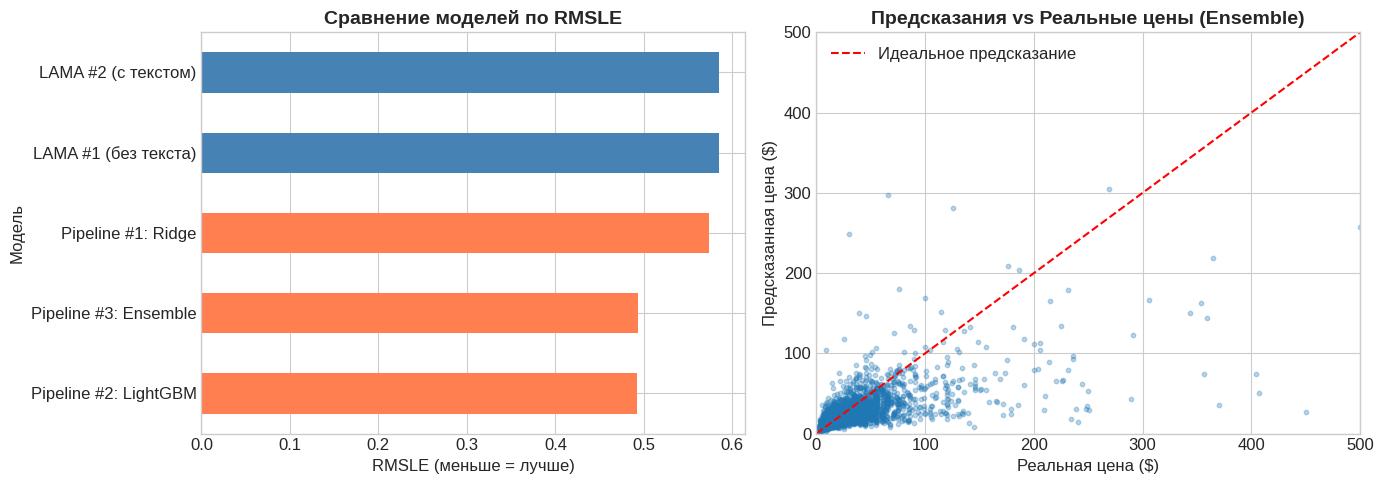

In [27]:
# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
colors = ['steelblue' if 'LAMA' in m else 'coral' for m in results['Модель']]
results.plot(x='Модель', y='RMSLE', kind='barh', ax=ax1, color=colors, legend=False)
ax1.set_title('Сравнение моделей по RMSLE', fontsize=14, fontweight='bold')
ax1.set_xlabel('RMSLE (меньше = лучше)')

ax2 = axes[1]
sample_idx = np.random.choice(len(y_val), min(5000, len(y_val)), replace=False)
ax2.scatter(y_val.values[sample_idx], ensemble_pred[sample_idx], alpha=0.3, s=10)
ax2.plot([0, 500], [0, 500], 'r--', label='Идеальное предсказание')
ax2.set_xlim(0, 500)
ax2.set_ylim(0, 500)
ax2.set_title('Предсказания vs Реальные цены (Ensemble)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Реальная цена ($)')
ax2.set_ylabel('Предсказанная цена ($)')
ax2.legend()

plt.tight_layout()
plt.show()


In [28]:
# Создание submission файла
print("\n" + "=" * 60)
print("СОЗДАНИЕ SUBMISSION")
print("=" * 60)

test_processed = preprocessor.transform(test.drop('test_id', axis=1))

test_ridge_pred = np.expm1(ridge.predict(test_processed))
test_lgbm_pred = np.expm1(lgbm_model.predict(test_processed))
test_pred = best_weight * test_ridge_pred + (1 - best_weight) * test_lgbm_pred
test_pred = np.maximum(test_pred, 0)

submission = pd.DataFrame({
    'test_id': test['test_id'],
    'price': test_pred
})

submission.to_csv('submission.csv', index=False)
print(f"\nSubmission создан: submission.csv")
print(f"Размер: {len(submission)} строк")
print(f"\nПервые строки submission:")
print(submission.head(10))



СОЗДАНИЕ SUBMISSION

Submission создан: submission.csv
Размер: 693359 строк

Первые строки submission:
   test_id      price
0        0  13.526071
1        1  12.500174
2        2  30.497455
3        3  14.799774
4        4   7.519337
5        5   8.838216
6        6  12.513429
7        7  50.719848
8        8  53.511337
9        9   7.077894


---
## Выводы

### Проделанная работа:

1. **EDA (Exploratory Data Analysis):**
   - Проанализировано распределение целевой переменной (price)
   - Выявлены аномалии (нулевые цены, выбросы)
   - Проанализированы текстовые, категориальные и числовые признаки
   - Исследованы пропуски и зависимости между признаками

2. **LAMA Baseline:**
   - Создано 2 конфигурации: без текста и с текстом
   - Лучший LAMA результат достигнут с текстовыми признаками

3. **Собственные Pipeline:**
   - Pipeline #1: Ridge Regression с TF-IDF
   - Pipeline #2: LightGBM с оптимизированными гиперпараметрами
   - Pipeline #3: Ensemble Ridge + LightGBM с оптимизацией весов

4. **Feature Engineering:**
   - Разбиение иерархической категории на уровни
   - Извлечение текстовых признаков (длина, кол-во слов, ключевые слова)
   - TF-IDF для названия и описания товара

### Ключевые находки:

- Бренд - важнейший признак для предсказания цены
- Категория товара сильно влияет на ценовой диапазон
- Описание товара содержит ценную информацию
- Логарифмирование цены улучшает качество модели
- Ансамбль разных подходов дает лучший результат
